# Part 1: Data collection demo
The objective of the project is to obtain user-generated content, i.e. reviews (including texts and images), from a platform called TripAdvisor. Given this objective, two functions are defined:
* Function 1 is created to acquire restaurant listings in one particular city, e.g. Amsterdam, from the TripAdvisor page which shows restaurants in this city.
* Function 2 is created to acquire reviews from a given restaurant listing, i.e. url obtained from the previous step.

In [1]:
# Import Python Libraries
import re
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from PIL import Image
from urllib import request
from io import BytesIO

In [2]:
def scrape_restaurants(url,pages_to_scrape):
    '''
    INPUTS:
        url: url to TripAdvisor page listing restaurants in a city (e.g. Amsterdam)
        pages_to_scrape: total number of pages (each showing restaurant listings) to scrape
    
    OUTPUT:
        restaurant_df: a DataFrame with some information about restaurant listings
    
    '''
    
    # REGULAR EXPRESSION
    regex = re.compile('[a-zA-Z]')
    # DRIVER
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)
    
    # ACCEPT PRIVACY OPTION
    time.sleep(18)
    driver.find_element("xpath",".//button[@id='onetrust-accept-btn-handler']").click()
    
    # EMPTY DATAFRAME TO STORE DATA
    restaurant_df = pd.DataFrame(columns=["RESTAURANT_URL",
                                          "RESTAURANT_NAME",
                                          "RESTAURANT_CATEGORY"])
    
    idx = 0
    for p in range(0,pages_to_scrape):
        print("Page: {p}/{pages_to_scrape}".format(
            p=p+1,
            pages_to_scrape=pages_to_scrape))
        time.sleep(2)
        names = driver.find_elements("xpath","//div[@class='biGQs _P fiohW alXOW NwcxK GzNcM ytVPx UTQMg RnEEZ ngXxk']")
        urls = driver.find_elements("xpath","//a[@class='BMQDV _F Gv wSSLS SwZTJ FGwzt ukgoS']")
        urls = urls[-len(names):]
        categories = driver.find_elements("xpath","//span[@class='YECgr']")
        categories = categories[-len(names):]
        for i in range(len(names)):
            restaurant_name = names[i].text.split(". ", 1)[-1]
            restaurant_url = urls[i].get_attribute('href')
            restaurant_category = regex.sub("",categories[i].text).replace("\n","").replace(",","").strip()
            restaurant_df.loc[idx] = [restaurant_url,restaurant_name,restaurant_category]
            idx += 1
            time.sleep(0.5)
        
        # CLICK ON "NEXT" BUTTON TO MOVE TO NEXT PAGE
        #button = WebDriverWait(driver, 60).until(
        #    EC.element_to_be_clickable(("xpath",".//a[@class='nav next rndBtn ui_button primary taLnk']")))
        #driver.execute_script('arguments[0].click()', button)
    driver.quit()
    return restaurant_df

In [3]:
# Define inputs
# URL to restaurant listings in Amsterdam on TripAdvisor
url = 'https://www.tripadvisor.com/Restaurants-g188590-Amsterdam_North_Holland_Province.html'
pages_to_scrape = 1

# Apply function
restaurants_df = scrape_restaurants(url,pages_to_scrape)

/var/folders/p9/fq129zpd59d4jwlgzrl1sgq80000gp/T/ipykernel_57769/1512592149.py:15: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


Page: 1/1


In [4]:
restaurants_df.head(3)

,RESTAURANT_URL,RESTAURANT_NAME,RESTAURANT_CATEGORY
0,https://www.tripadvisor.com/Restaurant_Review-...,Mount Everest Tandoori,165
1,https://www.tripadvisor.com/Restaurant_Review-...,Graham's Kitchen,
2,https://www.tripadvisor.com/Restaurant_Review-...,de Silveren Spiegel,


In [5]:
def scrape_reviews(url,pages_to_scrape,restaurant_name,restaurant_category):
    # WEBDRIVER OPTIONS
    options = webdriver.ChromeOptions() 
    options.add_argument("start-maximized")
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)
    # WEBDRIVER
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)
    
    # ACCEPT PRIVACY OPTION
    time.sleep(59)
    driver.find_element("xpath",".//button[@id='onetrust-accept-btn-handler']").click()
    
    # SELECT REVIEWS OF ALL LANGUAGES
    driver.find_element("xpath",".//label[@for='filters_detail_language_filterLang_ALL']").click()
    time.sleep(4)
    
    # RESTAURANT ADDRESS
    address_element = driver.find_elements("xpath","//a[@class='AYHFM']")
    restaurant_address = [a.text for a in address_element if "The Netherlands" in a.text][-1]
    
    # EMPTY DATAFRAME WITH COLUMN NAMES
    columns = ["RESTAURANT_NAME","RESTAURANT_ADDRESS","RESTAURANT_CATEGORY",
               "REVIEW_ID","DATE","TITLE","TEXT","RATING","PHOTO_URL"]
    reviews_df = pd.DataFrame(columns=columns)
    
    idx = 0
    page = 0
    while page < pages_to_scrape:
        print("Restaurant: {restaurant_name}\t\tPage: {page}".format(
            restaurant_name=restaurant_name,
            page=page+1))
        
        
        # RESTAURANT REVIEW
        try:
            container = driver.find_elements("xpath","//div[@class='review-container']")
            for i in range(0,len(container)):
                # EMPTY LIST TO STORE DATA
                lst = []
                # REVIEW ID
                review_id = container[i].get_attribute("data-reviewid")
                
                # REVIEW DATE
                review_date = container[i].find_element(
                    "xpath",".//span[contains(@class, 'ratingDate')]").get_attribute("title")
                
                # REVIEW TITLE
                review_title = container[i].find_element(
                    "xpath",".//span[contains(@class, 'noQuotes')]").text
                
                # REVIEW TEXT
                review_text_element = container[i].find_element(
                    "xpath",".//p[@class='partial_entry']")
                review_text = review_text_element.text
                # Post Snippet
                post_snippet = ""
                review_text_element_children = review_text_element.find_elements(
                    "xpath",".//*")
                for j in range(len(review_text_element_children)):
                    if review_text_element_children[j].get_attribute("class")=="postSnippet":
                        post_snippet = review_text_element_children[j].get_attribute("innerHTML")
                        review_text = " ".join([review_text,post_snippet])
                review_text = review_text.replace("...More","")
                
                # REVIEW RATING
                review_rating = container[i].find_element(
                    "xpath",".//span[contains(@class, 'ui_bubble_rating bubble_')]").get_attribute(
                        "class").split("_")[3]
                
                # SCROLL TO REVIEW
                review = driver.find_element(
                    "xpath","//div[@data-reviewid='{review_id}']".format(
                        review_id=review_id))
                driver.execute_script("arguments[0].scrollIntoView({block:'center'});",review)
                
                # REVIEW IMAGES
                photos_wrapper = container[i].find_elements(
                    "xpath",".//div[@class='inlinePhotosWrapper']")
                review_photos = []
                if photos_wrapper != []:
                    photos_wrapper_children = photos_wrapper[-1].find_elements(
                        "xpath",".//*")
                    for k in range(len(photos_wrapper_children)):
                        if photos_wrapper_children[k].tag_name == "img":
                            review_photos.append(photos_wrapper_children[k].get_attribute("src"))
                if review_photos == []:
                    review_photos = ""
                else:
                    review_photos = list(set(review_photos))
                lst = [restaurant_name,restaurant_address,restaurant_category,
                       review_id,review_date,review_title,review_text,review_rating,
                       review_photos]
                reviews_df.loc[idx] = lst
                idx += 1
            page += 1
        except:
            print('\tRetry page {page}'.format(page=page+1))
            continue
        try:
            time.sleep(2)
            driver.find_elements(
                "xpath",".//a[@class='nav next ui_button primary']")[0].click()
            time.sleep(3)
        except:
            break
    # CLOSE THE CURRENT WINDOW
    driver.close()
    
    reviews_df = reviews_df.explode("PHOTO_URL")
    # DROP DUPLICATES (IF ANY)
    reviews_df = reviews_df.drop_duplicates(keep='first')
    reviews_df = reviews_df.reset_index(drop=True)
    return reviews_df


def display_image(url):
    res = request.urlopen(url).read()
    img = Image.open(BytesIO(res))
    display(img)
    return img

In [7]:
# Create some data for demo
url = 'https://www.tripadvisor.com/Restaurant_Review-g188590-d13511379-Reviews-Restaurant_Bougainville-Amsterdam_North_Holland_Province.html'
restaurant_name = 'Restaurant Bougainville'
restaurant_category = '$$$$'
pages_to_scrape = 1
# Apply function
reviews_df = scrape_reviews(url,pages_to_scrape,restaurant_name,restaurant_category)
reviews_df.head(5)

/var/folders/p9/fq129zpd59d4jwlgzrl1sgq80000gp/T/ipykernel_57769/1595129780.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


Restaurant: Restaurant Bougainville		Page: 1


,RESTAURANT_NAME,RESTAURANT_ADDRESS,RESTAURANT_CATEGORY,REVIEW_ID,DATE,TITLE,TEXT,RATING,PHOTO_URL
0,Restaurant Bougainville,"Dam 27 In Hotel TwentySeven, 1012 JS Amsterdam...",$$$$,925038788,"November 8, 2023",Heeft de verwachting waargemaakt,"Mooie beleving in een prachtig pand, Service i...",50,https://media-cdn.tripadvisor.com/media/photo-...
1,Restaurant Bougainville,"Dam 27 In Hotel TwentySeven, 1012 JS Amsterdam...",$$$$,857982244,"September 2, 2022",A wonderful experience!,We went to Bougainville for the first time thi...,50,
2,Restaurant Bougainville,"Dam 27 In Hotel TwentySeven, 1012 JS Amsterdam...",$$$$,924874629,"November 6, 2023",Super restaurant maar zeker niet de beste van ...,"Super tof restaurant, onwijs lekker gegeten en...",40,https://media-cdn.tripadvisor.com/media/photo-...
3,Restaurant Bougainville,"Dam 27 In Hotel TwentySeven, 1012 JS Amsterdam...",$$$$,924874629,"November 6, 2023",Super restaurant maar zeker niet de beste van ...,"Super tof restaurant, onwijs lekker gegeten en...",40,https://media-cdn.tripadvisor.com/media/photo-...
4,Restaurant Bougainville,"Dam 27 In Hotel TwentySeven, 1012 JS Amsterdam...",$$$$,924874629,"November 6, 2023",Super restaurant maar zeker niet de beste van ...,"Super tof restaurant, onwijs lekker gegeten en...",40,https://media-cdn.tripadvisor.com/media/photo-...


In [8]:
reviews_df.loc[0,'TITLE']

'Heeft de verwachting waargemaakt'

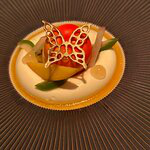

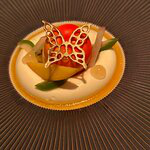

In [9]:
display_image(reviews_df.loc[0,'PHOTO_URL'])

# Part 2: Image analysis demo
In this research, I am interested in the photographic attributes of user-generated content on TripAdvisor, i.e. the review photographs. I define several attributes based on previous studies, including brightness, contrast, colorfulness, color variety, rule of thirds, visual balance, sharpness and depth of field. In this demo, I will show how visual balance was defined in a previous study and how I use the definition to define a function which computes the visual balance of an image.

<img src="Screenshot 2023-11-13 at 11.17.42.png" width=500 height=500 />
(screenshot is taken from my thesis)

In [15]:
# Import Python Libraries
from PIL import Image, ImageStat
from urllib import request
from io import BytesIO
import numpy as np
import cv2 as cv
from skimage import io, color, segmentation, graph, measure
from scipy import ndimage
import matplotlib.pyplot as plt

In [13]:
def saliency_spectral_residual(url):
    # READ IMAGE AND CONVERT TO GRAYSCALE
    res = request.urlopen(url,timeout=15).read()
    img = Image.open(BytesIO(res))
    gray = img.convert('L')
    gray = np.array(gray)
    
    # CV2 SALIENCY
    saliency = cv.saliency.StaticSaliencySpectralResidual_create()
    success, saliency_map = saliency.computeSaliency(gray)
    saliency_map = (saliency_map * 255).astype("uint8")
    return saliency_map
    
    
def center_of_mass(url):
    saliency_map = saliency_spectral_residual(url)
    
    # IMAGE SHAPE
    h,w = saliency_map.shape
    
    # CENTER OF MASS COORDINATE
    com_x, com_y = ndimage.center_of_mass(saliency_map)
    # SCALE CENTER OF MASS
    com_x = com_x/h 
    com_y = com_y/w
    return com_x, com_y

def visual_balance(url):
    """
    VISUAL BALANCE IS DETERMINED BY THE DEVIATION OF THE CENTER OF MASS
    (DCM)
    """
    # COMPUTE CENTER OF MASS
    com_x, com_y = center_of_mass(url)
    dcm_x = abs(com_x - 1/2)
    dcm_y = abs(com_y - 1/2)
    
    # COMPUTE DEVIATION OF THE CENTER OF MASS
    dcm = (dcm_x**2 + dcm_y**2)
    dcm = np.sqrt(dcm)
    dcm = dcm/0.5
    dcm = dcm*100
    return dcm

# Part 3: Data visualization demo

In [18]:
# Import Python Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# Import DataFrame (csv file)
df = pd.read_csv('./all_attributes.csv')

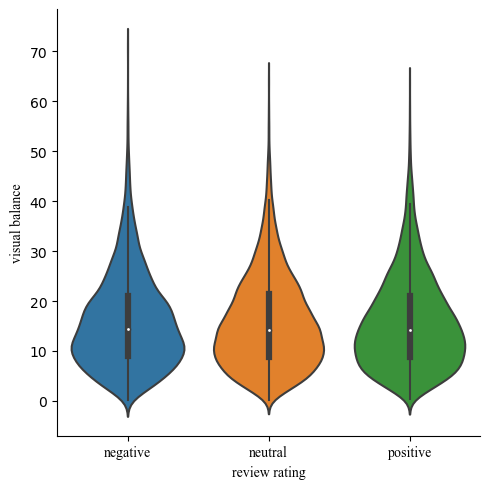

In [21]:
sns.catplot(kind='violin',data=df,x='GROUPED_RATING',y='VISUAL_BALANCE')
plt.xticks([0,1,2],['negative','neutral','positive'],fontname='Times New Roman')
plt.xlabel('review rating',fontname='Times New Roman')
plt.ylabel('VISUAL_BALANCE'.replace('_',' ').lower(),fontname='Times New Roman')
plt.show()